# Bank Churn Models

Clients have started leaving "N Bank." Every month. Not a lot, but it's noticeable. Bank marketers calculated that retaining current clients is cheaper than attracting new ones..

I need to predict whether a customer will leave our bank in the near future or not. I have been provided with historical data on customer behavior and termination of contracts with our bank.

I will build a model with the maximum possible F1 score. To pass this project successfully, I need to bring the F1 score up to 0.59. I will verify the F1 score on the test set independently.

Additionally, I will measure the AUC-ROC and compare its value with the F1 score.

Source of data: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Features**
* `RowNumber` — index of a row in the dataset
* `CustomerId` — unique identifier of a custome
* `Surname` — surname
* `CreditScore` — credit rating
* `Geography` — country of residence
* `Gender` — gender
* `Age` — age
* `Tenure` — number of years the customer has been with the bank
* `Balance` — account balance
* `NumOfProducts` — number of bank products used by the customer
* `HasCrCard` — presence of a credit card
* `IsActiveMember` — customer's activity
* `EstimatedSalary` — estimated salary

**Target**
* `Exited` — the fact of a customer leaving

# Data preparation

- [x]  Investigate missing data (process if necessary).Текст, выделенный полужирным шрифтом
- [x]  Investigate categorical data types (use One-Hot Encoding if necessary).
- [x]  Split the dataset into training, validation, and testing sets.
- [x]  Investigate numerical data types (standardize if necessary).

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

from scipy.stats import ttest_ind
from sklearn.metrics import roc_curve, confusion_matrix

In [2]:
# Load the dataset and check its size
df = pd.read_csv('/kaggle/input/churn-modelling/Churn_Nan.csv')
# Save the original dataset to the variable df_raw
df_raw = df.copy()

df.shape

(10000, 14)

In [3]:
# Print the first five rows of the dataset
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
# Transform column names to lowercase
df.columns = (df.columns).str.lower()
df = df.rename(columns={'rownumber':'row_number','customerid':'customer_id','creditscore':'credit_score'
                        ,'numofproducts':'num_of_products','hascrcard':'has_cr_card'
                        ,'isactivemember':'is_active_member','estimatedsalary':'estimated_salary'})

### Investigation of missing data

In [5]:
# Check for missing values and data types in column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
# Examine missing data more closely
df[df['tenure'].isna()].head(10)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


In [7]:
# Count the unique values in the tenure column.
df.value_counts('tenure').sort_values()

tenure
0.0     382
10.0    446
6.0     881
9.0     882
4.0     885
7.0     925
5.0     927
3.0     928
8.0     933
2.0     950
1.0     952
dtype: int64

In [8]:
# Check the relationship between tenure values and customer_id
# Usually, id is assigned sequentially for each new object
df.sort_values('customer_id').head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
1287,1288,15565701,Ferri,698,Spain,Female,39,9.0,161993.89,1,0,0,90212.38,0
4198,4199,15565706,Akobundu,612,Spain,Male,35,1.0,0.00,1,1,1,83256.26,1
7090,7091,15565714,Cattaneo,601,France,Male,47,1.0,64430.06,2,0,1,96517.97,0
2020,2021,15565779,Kent,627,Germany,Female,30,6.0,57809.32,1,1,0,188258.49,0
3697,3698,15565796,Docherty,745,Germany,Male,48,10.0,96048.55,1,1,0,74510.65,0


When using classification models from the scikit-learn (sklearn) library, if there are NaN values in the dataset, it is necessary to handle these missing values correctly. Here are several strategies that can be considered:

* **Filling the missing values**: one strategy for working with missing data is to fill them with some reasonable value. The simplest approach is to replace missing values with the mean, median, or mode of the feature column. However, more complex methods can also be used, such as filling in based on K-nearest neighbors (KNN) or filling in using other models such as decision trees or random forests.
* **Deletion**: Another strategy is to delete rows or columns with missing values. However, when using this strategy, it is important to be cautious, especially if we have many missing values or if the missing values are not randomly distributed throughout the dataset.

In the original dataset, there are only missing values for the `tenure` column (how many years a person has been a bank customer). Upon a cursory examination of the data, we could not determine the reason for the missing values or find any correlation with other columns.

The number of missing values in the column is about 9% of the total number of values in that column.

* Such a proportion of missing values is usually not critical for deletion, but we should also consider the option of filling in the missing values.

* After calculating the unique values in the column, we can see that the fewest clients (382) have been with the bank for less than a year (feature value = 0). It is possible to assume that the missing values in the data are relevant to this category of clients. Therefore, they can be processed by filling in with a value of "0".


To check this hypothesis, we will create two datasets (one with missing values removed and the other with missing values filled with "0") and compare the classification results.


Before removing missing values, we will preliminarily test hypotheses about the equality of means in the numerical features of the two samples (original and after removal of missing values).

**Let's formulate the hypotheses:**

* H₀ - Null hypothesis - The means of the numerical feature in the samples are equal.
* H₁ - Alternative hypothesis - The means of the numerical feature in the samples are not equal.

_By samples, I mean the original dataset and the dataset after removing missing values._

In [9]:
# Function for testing hypotheses about the equality of values from samples

def ttest_na_df(df=df, alpha=0.05):
    
    
    for col in df.select_dtypes(include=['int64','float64']).columns:
        subset = df[col]
        subset_dropped = df.dropna()[col]
        
        try:
            t_stat, p_value = ttest_ind(subset, subset_dropped, equal_var=True)
            print('Feature:', col)
            print('p-value:', p_value)
            if p_value < alpha:
                print('We reject the null hypothesis','\n')
                
            else:
                print('We failed to reject the null hypothesis','\n')
                
        except:
            print(f'Feature: {col} something went wrong!','\n')

In [10]:
# Test hypotheses for our features
ttest_na_df()

Feature: row_number
p-value: 0.7484615653552151
We failed to reject the null hypothesis 

Feature: customer_id
p-value: 0.9138124277302712
We failed to reject the null hypothesis 

Feature: credit_score
p-value: 0.8819458589489737
We failed to reject the null hypothesis 

Feature: age
p-value: 0.8574667702064644
We failed to reject the null hypothesis 

Feature: tenure
p-value: nan
We failed to reject the null hypothesis 

Feature: balance
p-value: 0.9674755453963604
We failed to reject the null hypothesis 

Feature: num_of_products
p-value: 0.9994978565520835
We failed to reject the null hypothesis 

Feature: has_cr_card
p-value: 0.9376271388604607
We failed to reject the null hypothesis 

Feature: is_active_member
p-value: 0.9488263246446845
We failed to reject the null hypothesis 

Feature: estimated_salary
p-value: 0.9131579855792714
We failed to reject the null hypothesis 

Feature: exited
p-value: 0.9674864614792923
We failed to reject the null hypothesis 



The p-value indicates the probability of obtaining such or greater statistical difference between two groups by chance, assuming that the null hypothesis is true.

1. The feature `tenure` contains NaN values in the original dataset, therefore it was not possible to test hypotheses for it.
2. For the remaining numerical features, we can confidently say that we failed to reject the null hypothesis that the mean values of the numerical feature in the samples are equal.


It has been decided that we can remove the missing values in the `tenure` column. We will do this after we examine our original dataset and optimize/regularize the values.

### Categorical features

In [11]:
# Create a dataset with categorical features
obj_col = df.select_dtypes(include=['object'])
# Look at the number of unique values in the columns
obj_col.nunique()

surname      2932
geography       3
gender          2
dtype: int64

The `surname` feature has 2932 unique values, and the One-Hot Encoding technique is not suitable here. It is better to use Ordinal Encoding, but this method is not suitable for logistic regression.

* It has been decided to remove the 'surname' column.

As for the `geography` and `gender` features, we will use the One-Hot Encoding technique for them.

In [12]:
# Delete the categorical feature 'surname
df = df.drop(columns='surname')

In [13]:
# Examine the relationship between categorical features and missing values
df['is_na'] = df['tenure'].isna().astype('int')
df.groupby(['geography', 'gender'])['is_na'].agg(['mean','sum']).rename(columns={'sum':'count_na'})

mean  count_na
geography gender                    
France    Female  0.095975       217
          Male    0.089720       247
Germany   Female  0.090528       108
          Male    0.082067       108
Spain     Female  0.092746       101
          Male    0.092219       128

In [14]:
# Delete the new column after analysis
df = df.drop(columns='is_na')
df.shape

(10000, 13)

From the calculation above, we can see that the proportion of missing values for different categories is in the range of 9% to 9.6%.

* I can assume that there will not be a significant imbalance in these features after removing objects with missing values.

In [15]:
# Transform the categorical features 'geography' and 'gender'
df_ohe = pd.get_dummies(df, drop_first=True).copy()

In [16]:
# Convert the column names to lowercase
df_ohe.columns = (df_ohe.columns).str.lower()
df_ohe.head().T

,0,1,2,3,4
row_number,1.00,2.00,3.00,4.00,5.00
customer_id,15634602.00,15647311.00,15619304.00,15701354.00,15737888.00
credit_score,619.00,608.00,502.00,699.00,850.00
age,42.00,41.00,42.00,39.00,43.00
tenure,2.00,1.00,8.00,1.00,2.00
balance,0.00,83807.86,159660.80,0.00,125510.82
num_of_products,1.00,1.00,3.00,2.00,1.00
has_cr_card,1.00,0.00,1.00,0.00,1.00
is_active_member,1.00,1.00,0.00,0.00,1.00
estimated_salary,101348.88,112542.58,113931.57,93826.63,79084.10


In [17]:
# Check the size of the resulting dataframe
df_ohe.shape

(10000, 14)

The categorical data was analyzed and transformed.

* It was decided to remove the `surname` feature. It can be assumed that the probability of a customer leaving the bank does not depend on their name. 
* The `geography` and `gender` features were transformed using the OHE technique with the removal of the first column for each feature to avoid the "dummy variable trap". The OHE technique is suitable for encoding categorical features and subsequent use of the resulting datasets in models such as logistic regression, decision trees, and random forests.

### Numerical features

In [18]:
# Check the distribution of numeric values in the columns
df_ohe.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.545700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.497932
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


From the data overview, it is evident that some features have a large range, and it is necessary to perform data standardization. We will use the _StandardScaler_ structure from the _sklearn.preprocessing_ library, but only after splitting the original dataset into training, validation, and testing sets.

The original dataset has a feature called `row_number`, and I assume that this feature does not characterize the object and is just an ordinal number of the record. Such a feature would negatively affect the training of the linear regression model. (This hypothesis was not tested.)

It has been decided to remove the `row_number` feature from the dataset!!!

In [19]:
# Delete row_number feature
df_ohe = df_ohe.drop(columns='row_number')
df_ohe.shape

(10000, 13)

In [20]:
# Check dataframe info
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        10000 non-null  int64  
 1   credit_score       10000 non-null  int64  
 2   age                10000 non-null  int64  
 3   tenure             9091 non-null   float64
 4   balance            10000 non-null  float64
 5   num_of_products    10000 non-null  int64  
 6   has_cr_card        10000 non-null  int64  
 7   is_active_member   10000 non-null  int64  
 8   estimated_salary   10000 non-null  float64
 9   exited             10000 non-null  int64  
 10  geography_germany  10000 non-null  uint8  
 11  geography_spain    10000 non-null  uint8  
 12  gender_male        10000 non-null  uint8  
dtypes: float64(3), int64(7), uint8(3)
memory usage: 810.7 KB


In [21]:
# Convert data types for 'has_cr_card' 'is_active_member' to uint8
cols_to_convert = ['has_cr_card', 'is_active_member']
df_ohe[cols_to_convert] = df_ohe[cols_to_convert].astype('uint8')
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        10000 non-null  int64  
 1   credit_score       10000 non-null  int64  
 2   age                10000 non-null  int64  
 3   tenure             9091 non-null   float64
 4   balance            10000 non-null  float64
 5   num_of_products    10000 non-null  int64  
 6   has_cr_card        10000 non-null  uint8  
 7   is_active_member   10000 non-null  uint8  
 8   estimated_salary   10000 non-null  float64
 9   exited             10000 non-null  int64  
 10  geography_germany  10000 non-null  uint8  
 11  geography_spain    10000 non-null  uint8  
 12  gender_male        10000 non-null  uint8  
dtypes: float64(3), int64(5), uint8(5)
memory usage: 674.0 KB


In [22]:
# Create the list with numeric features
numeric = df_ohe.select_dtypes(include=['int64','float64']).columns.to_list()
# Remove hte feature 'exited' from 'numeric'
numeric = [x for x in numeric if x != 'exited']
numeric

['customer_id',
 'credit_score',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'estimated_salary']

### Training, validation and testing subsets.

After splitting the datasets (with deleted missing values and filled with 0 values), it is necessary to standardize the numeric data.

In [23]:
# Create two subsets
df_drop = df_ohe.dropna().copy()
print('Size of df with dropped NaNs:',df_drop.shape)
df_fill = df_ohe.fillna(0).copy()
print('Size of df with filled NaNs:',df_fill.shape)

Size of df with dropped NaNs: (9091, 13)
Size of df with filled NaNs: (10000, 13)


In [24]:
# Split to features и target (Dropped subset)
features_drop = df_drop.drop(columns=['exited'])
target_drop = df_drop.exited[features_drop.index]

print(features_drop.shape)
print(target_drop.shape)

(9091, 12)
(9091,)


In [25]:
# Split to features и target (Filled subset)
features = df_fill.drop(columns='exited')
target = df_fill.exited[features.index]

print(features.shape)
print(target.shape)

(10000, 12)
(10000,)


Split the resulting datasets into training and test sets in an 80/20 ratio.

In [26]:
# Split the data into training and testing sets
features_train_drop, features_test_drop, target_train_drop, target_test_drop = train_test_split(
    features_drop, target_drop, test_size=0.2, random_state=42, stratify=target_drop)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

In [27]:
# Print size of sets (Dropped version)
print('X_train_drop:',features_train_drop.shape)
print('y_train_drop:',target_train_drop.shape,'\n')

print('X_test_drop:',features_test_drop.shape)
print('y_test_drop:',target_test_drop.shape)

X_train_drop: (7272, 12)
y_train_drop: (7272,) 

X_test_drop: (1819, 12)
y_test_drop: (1819,)


In [28]:
# Print size of sets (Filled version)
print('X_train:',features_train.shape)
print('y_train:',target_train.shape,'\n')

print('X_test:',features_test.shape)
print('y_test:',target_test.shape)

X_train: (8000, 12)
y_train: (8000,) 

X_test: (2000, 12)
y_test: (2000,)


Split the resulting training sets into new training and validation sets. In a ratio of 75/25.

In [29]:
# Split the training set into new training and validation sets
features_train_drop, features_valid_drop, target_train_drop, target_valid_drop = train_test_split(
    features_train_drop, target_train_drop, test_size=0.25, random_state=42, stratify=target_train_drop)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=42, stratify=target_train)

In [30]:
# Print size of sets (Dropped version)
print('X_train_drop:',features_train_drop.shape)
print('y_train_drop:',target_train_drop.shape,'\n')

print('X_valid_drop:',features_valid_drop.shape)
print('y_valid_drop:',target_valid_drop.shape)

X_train_drop: (5454, 12)
y_train_drop: (5454,) 

X_valid_drop: (1818, 12)
y_valid_drop: (1818,)


In [31]:
# Print size of sets (Filled version)
print('X_train:',features_train.shape)
print('y_train:',target_train.shape,'\n')

print('X_valid:',features_test.shape)
print('y_valid:',target_test.shape)

X_train: (6000, 12)
y_train: (6000,) 

X_valid: (2000, 12)
y_valid: (2000,)


In [32]:
# Perform standardization for the datasets
sets_drop = [features_train_drop, features_valid_drop, features_test_drop]
sets = [features_train, features_valid, features_test]

scaler = StandardScaler()

scaler.fit(features_train_drop[numeric])

for s in sets_drop:
    s[numeric] = scaler.transform(s[numeric])
    
scaler.fit(features_train[numeric])

for s in sets:
    s[numeric] = scaler.transform(s[numeric])

features_valid_drop.describe()

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
count,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000,1818.000000
mean,-0.027233,0.002050,-0.024827,0.010316,-0.010389,0.006654,0.702420,0.490099,0.004428,0.238174,0.243674,0.556106
std,0.998388,0.983222,0.972742,1.020237,1.009481,1.002151,0.457319,0.500040,1.022949,0.426083,0.429417,0.496979
min,-1.746923,-3.014973,-1.976120,-1.732966,-1.240299,-0.907853,0.000000,0.000000,-1.745449,0.000000,0.000000,0.000000
25%,-0.883092,-0.693911,-0.660579,-1.038328,-1.240299,-0.907853,0.000000,0.000000,-0.884734,0.000000,0.000000,0.000000
50%,-0.077604,0.028197,-0.190743,0.003630,0.327872,-0.907853,1.000000,0.000000,0.013048,0.000000,0.000000,1.000000
75%,0.845082,0.698726,0.467028,1.045587,0.818294,0.820395,1.000000,1.000000,0.906750,0.000000,0.000000,1.000000
max,1.732820,2.060416,4.319685,1.740226,2.593767,4.276892,1.000000,1.000000,1.749223,1.000000,1.000000,1.000000


Standardization of numeric data was performed using _StandardScaler_ from the _sklearn_ library.

The target feature `exited` was left unchanged.

### Conclusion after data preparation

* We have a dataset that includes features of objects and a target variable (whether or not the client has churned) that needs to be predicted based on those features. 
    * Such tasks belong to the **supervised learning** class. 
    * The target variable is categorical, so the task is a **classification problem**. We have two values (0 and 1), so it is a **binary classification**.


* There are missing values in the original dataset, and two methods of processing (deleting and filling missing values with 0) will be used. 
* The original dataset has 10000 objects and 14 features for each object, including the target variable.
* After transformation, the resulting dataset has 10000/9091 objects and 13 features, including the target variable.
* Categorical features are processed using the OHE method. Numeric features have been analyzed and processed using standardization.
* The processed dataset is divided into a 3/5 training, 1/5 validation, and 1/5 test samples. 
* The target variable values in the original dataset are unevenly distributed at 20/80.

# Task investigation

* [x]  Explore class balance
* [x]  Fit models without taking into account class imbalance
* [x]  Write conclusions based on research results

### Balancing classes investigation

Earlier during data preparation, we saw that our target variable has a class imbalance.

* Class 1 (customer left the bank) has a share of approximately 20%
* Class 0 (customer still serviced by the bank) has a share of approximately 80%


To handle class imbalance, different techniques can be used:

* Class weighting - assign a higher weight to rare class objects. (In sklearn models, the class_weight argument)
* Upsampling - copying rare class objects and adding them to the dataset.
* Downsampling - removing frequent class objects from the dataset.

We will conduct the task of working with class imbalance after training the models on existing datasets.

In [33]:
# Check the class 1
df_drop.exited.mean()

0.2039379606203938

In [34]:
# Class imbalance in train/valid/test sets
print(f'Proportion of the rare class - train: {target_train.mean():.4f}')
print(f'Proportion of the rare class - valid: {target_valid.mean():.4f}')
print(f'Proportion of the rare class - test: {target_test.mean():.4f}')

Proportion of the rare class - train: 0.2038
Proportion of the rare class - valid: 0.2035
Proportion of the rare class - test: 0.2035


Since we used the `stratify` argument when splitting the dataset into samples using the train_test_split function, the proportion of the rare class in these samples is approximately 20%, as in our original data.

To solve the binary classification task, we will use several classifier models:

1. Logistic regression
2. Decision tree
3. Random forest

For training and validation of each model, two sets of samples will be used (with missing values removed and with missing values filled).

### Logistic regression model

In [35]:
# Train the LogisticRegression model
lrc = LogisticRegression(random_state=414925, solver='lbfgs', max_iter=1000) 
lrc.fit(features_train_drop, target_train_drop)
print('Accuracy:',lrc.score(features_valid_drop, target_valid_drop))

Accuracy: 0.8151815181518152


#### Model adequacy check

In [36]:
# Create a constant model that predicts the class "0" for any object
target_pred_constant = pd.Series([0]*len(target_valid_drop.index), index=target_valid_drop.index)
print('Accuracy Constatnt model:',accuracy_score(target_valid_drop,target_pred_constant))

Accuracy Constatnt model: 0.7959295929592959


#### Metrics

When comparing the Accuracy metrics of our Logistic Regression model and the Constant model with a prediction of the dominant class "0", we can see that the score values differ slightly. Therefore, relying solely on the Accuracy  to understand how well our model predicts the target feature is not reliable due to the class imbalance.

* It is necessary to additionally look at the aggregated F1-score metric to evaluate the balance between Recall and Precision.

* Recall describes how well the model understood the features of the "1" class and recognized it.

* Precision detects whether the model overestimated, assigning positive labels.

In [37]:
# Calculate F1-score for LogisticRegression model
predicted_labels_drop = lrc.predict(features_valid_drop)
f1 = f1_score(target_valid_drop, predicted_labels_drop)
# Calculate ROC AUC score for LogisticRegression model
y_pred_prob = lrc.predict_proba(features_valid_drop)[:, 1]
roc_auc = roc_auc_score(target_valid_drop, y_pred_prob)

print("F1-score: {:.3f}".format(f1))
print(f'ROC AUC score: {roc_auc:.3f}','\n')

# Calculate F1-score for Constant model
f1 = f1_score(target_valid_drop, target_pred_constant, zero_division=1)
# Calculate ROC AUC score for Constantn model
roc_auc = roc_auc_score(target_valid_drop, target_pred_constant)
print("F1-score for Constant mode: {:.3f}".format(f1))
print(f'ROC AUC score for Constantn model: {roc_auc:.3f}')

F1-score: 0.303
ROC AUC score: 0.764 

F1-score for Constant mode: 0.000
ROC AUC score for Constantn model: 0.500


In [38]:
# Train LogisticRegression model (Filled version)
lrc = LogisticRegression(random_state=414925, solver='lbfgs', max_iter=1000)
lrc.fit(features_train, target_train)
# Calculate F1-score for LogisticRegression model
predicted_labels = lrc.predict(features_valid)
f1 = f1_score(target_valid, predicted_labels)
# Calculate ROC AUC score for LogisticRegression model
y_pred_prob = lrc.predict_proba(features_valid)[:, 1]
roc_auc = roc_auc_score(target_valid, y_pred_prob)

print("F1-score: {:.3f}".format(f1))
print(f'ROC AUC score: {roc_auc:.3f}','\n')

F1-score: 0.318
ROC AUC score: 0.757 



#### Logistic Regression - Validation Results

The results for different samples are different:

1. Samples with removed missing values.
* F1 score: 0.303
* ROC AUC score: 0.764
2. Samples with filled missing values.
* F1 score: 0.318
* ROC AUC score: 0.757

### Decision tree model

As with the logistic regression model, we will conduct training and validation on two datasets:

1. Datasets with missing values removed.(Dropped version)
2. Datasets with missing values filled. (Filled version)

In [39]:
# Tune the hyperparameter max_depth
best_result = 0

for depth in range(3,15):
    dtc = DecisionTreeClassifier(random_state=414925, max_depth=depth)
    dtc.fit(features_train_drop,target_train_drop)
    target_pred = dtc.predict(features_valid_drop)
    result = f1_score(target_valid_drop, target_pred)
    if result > best_result:
        best_result_drop = result
        max_depth_drop = depth
        best_dtc_drop = dtc

# Calculate the ROC AUC score of the best model
y_pred_prob = best_dtc_drop.predict_proba(features_valid_drop)[:, 1]
roc_auc = roc_auc_score(target_valid_drop, y_pred_prob)

print('Results of the best model')       
print(f'F1 score: {best_result_drop:.3f}') 
print(f'ROC AUC score: {roc_auc:.3f}','\n')
print(f'max_depth = {max_depth_drop}') 

Results of the best model
F1 score: 0.555
ROC AUC score: 0.721 

max_depth = 14


In [40]:
# Tune the hyperparameter max_depth (Filled version)
best_result = 0

for depth in range(3,10):
    dtc = DecisionTreeClassifier(random_state=414925, max_depth=depth)
    dtc.fit(features_train,target_train)
    target_pred = dtc.predict(features_valid)
    result = f1_score(target_valid, target_pred)
    if result > best_result:
        best_result = result
        max_depth = depth
        best_dtc = dtc

# Calculate the ROC AUC score of the best model
y_pred_prob = best_dtc.predict_proba(features_valid)[:, 1]
roc_auc = roc_auc_score(target_valid, y_pred_prob)

print('Results of the best model (Filled version)')       
print(f'F1 score: {best_result:.3f}') 
print(f'ROC AUC score: {roc_auc:.3f}','\n')
print(f'max_depth = {max_depth}')  

Results of the best model (Filled version)
F1 score: 0.571
ROC AUC score: 0.835 

max_depth = 7


#### Decision Tree - Results of tuning max_depth.
The results of the Decision Tree model for different datasets are different:
    
1. Datasets with missing values removed. (Dropped version)
* F1 score: 0.555
* ROC AUC score: 0.721
* max_depth = 14

2. Datasets with missing values filled. (Filled version)
* F1 score: 0.571
* ROC AUC score: 0.835
* max_depth = 7
    
    
Let's continue tuning hyperparameters.

In [41]:
# Tune the hyperparameter min_samples_split
best_result = 0

for _ in range(2, 16):
    dtc = DecisionTreeClassifier(random_state=414925, max_depth=max_depth_drop, min_samples_split=_)
    dtc.fit(features_train_drop,target_train_drop)
    target_pred = dtc.predict(features_valid_drop)
    result_drop = f1_score(target_valid_drop, target_pred)
    if result_drop > best_result:
        best_result_drop = result_drop
        min_samples_split_drop = _
        best_dtc_drop = dtc

# Calculate the ROC AUC score of the best model
y_pred_prob = best_dtc_drop.predict_proba(features_valid_drop)[:, 1]
roc_auc = roc_auc_score(target_valid_drop, y_pred_prob)

print('Results of the best model')       
print(f'F1 score: {best_result_drop:.3f}') 
print(f'ROC AUC score: {roc_auc:.3f}','\n')
print(f'min_samples_split = {min_samples_split_drop}')

Results of the best model
F1 score: 0.546
ROC AUC score: 0.767 

min_samples_split = 15


In [42]:
# Tune the hyperparameter min_samples_split (Filled version)
best_result = 0

for _ in range(2, 16):
    dtc = DecisionTreeClassifier(random_state=414925, max_depth=max_depth, min_samples_split=_)
    dtc.fit(features_train,target_train)
    target_pred = dtc.predict(features_valid)
    result = f1_score(target_valid, target_pred)
    if result > best_result:
        best_result = result
        min_samples_split = _
        the_best_dtc = dtc

# Calculate the ROC AUC score of the best model
y_pred_prob = the_best_dtc.predict_proba(features_valid)[:, 1]
roc_auc = roc_auc_score(target_valid, y_pred_prob)

print('Results of the best model')       
print(f'F1 score: {best_result:.3f}') 
print(f'ROC AUC score: {roc_auc:.3f}','\n')
print(f'min_samples_split = {min_samples_split}')

Results of the best model
F1 score: 0.572
ROC AUC score: 0.839 

min_samples_split = 10


#### Decision tree - results of min_samples_split tuning
The results of the Decision Tree model for different samples are different:
    
1. Samples with removed missing values. (Dropped version)
* F1 score: 0.546
* ROC AUC score: 0.767
* min_samples_split = 15

2. Samples with filled missing values (Filled version)
* F1 score: 0.572
* ROC AUC score: 0.839  
* min_samples_split = 10

### Random Forest model

In [43]:
%%time
# Tune the hyperparameter max_depth
best_model = None
best_result = 0
for depth in range(1, 15):
    model = RandomForestClassifier(random_state=414925, n_estimators=10, max_depth=depth) 
    model.fit(features_train_drop, target_train_drop)
    target_pred = model.predict(features_valid_drop)
    result_drop = f1_score(target_valid_drop, target_pred)
    if result_drop > best_result:
        best_model_rfc_drop = model
        best_result_drop = result
        best_depth_drop = depth
# Calculate the ROC AUC score of the best model
y_pred_prob = best_model_rfc_drop.predict_proba(features_valid_drop)[:, 1]
roc_auc = roc_auc_score(target_valid_drop, y_pred_prob)
        
print('Results of the best model')       
print(f'F1 score: {best_result_drop:.3f}') 
print(f'ROC AUC score: {roc_auc:.3f}','\n')
print(f'max_depth = {best_depth_drop}','\n')

Results of the best model
F1 score: 0.572
ROC AUC score: 0.833 

max_depth = 14 

CPU times: user 957 ms, sys: 6.43 ms, total: 963 ms
Wall time: 963 ms


In [44]:
%%time
# Tune the hyperparameter max_depth (Filled version)
best_model = None
best_result = 0
for depth in range(1, 15):
    model = RandomForestClassifier(random_state=414925, n_estimators=10, max_depth=depth)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_valid)
    result = f1_score(target_valid, target_pred)
    if result > best_result:
        best_model_rfc = model
        best_result = result
        best_depth = depth
# Calculate the ROC AUC score of the best model
y_pred_prob = best_model_rfc.predict_proba(features_valid)[:, 1]
roc_auc = roc_auc_score(target_valid, y_pred_prob)

print('Results of the best model')       
print(f'F1 score: {best_result:.3f}') 
print(f'ROC AUC score: {roc_auc:.3f}','\n')
print(f'max_depth = {best_depth}','\n')

Results of the best model
F1 score: 0.532
ROC AUC score: 0.822 

max_depth = 12 

CPU times: user 1.03 s, sys: 2.31 ms, total: 1.03 s
Wall time: 1.03 s


#### Random Forest - results of max_depth tuning
The results of the Random forest model for different samples are different:
    
1. Samples with removed missing values. (Dropped version)
* F1 score: 0.572
* ROC AUC score: 0.833 
* max_depth = 14
* Wall time: 808 ms

2. Samples with filled missing values (Filled version)
* F1 score: 0.532
* ROC AUC score: 0.822  
* max_depth = 12
* Wall time: 834 ms

In [45]:
%%time
# Tune the hyperparameter n_estimators
best_result = 0
n_est = [10,20,40,60,80,100,200,300,400]
for est in n_est:
    model = RandomForestClassifier(random_state=414925, max_depth=best_depth_drop, n_estimators=est)
    model.fit(features_train_drop, target_train_drop)
    target_pred = model.predict(features_valid_drop)
    result = f1_score(target_valid_drop, target_pred)
    if result > best_result:
        the_best_model_rfc_drop = model
        best_result_drop = result
        best_n_estimators_drop = est
# Calculate the ROC AUC score of the best model
y_pred_prob = the_best_model_rfc_drop.predict_proba(features_valid_drop)[:, 1]
roc_auc = roc_auc_score(target_valid_drop, y_pred_prob)

print('Results of the best model')       
print(f'F1 score: {best_result_drop:.3f}') 
print(f'ROC AUC score: {roc_auc:.3f}','\n')
print(f'n_estimators = {best_n_estimators_drop}','\n')

Results of the best model
F1 score: 0.548
ROC AUC score: 0.864 

n_estimators = 400 

CPU times: user 10.8 s, sys: 70.6 ms, total: 10.9 s
Wall time: 10.9 s


In [46]:
%%time
# Tune the hyperparameter n_estimators (Filled version)
best_result = 0
n_est = [10,20,40,60,80,100,200,300,400]
for est in n_est:
    model = RandomForestClassifier(random_state=414925, max_depth=best_depth, n_estimators=est)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_valid)
    result = f1_score(target_valid, target_pred)
    if result > best_result:
        best_model_rfc = model
        best_result = result
        best_n_estimators = est
# Calculate the ROC AUC score of the best model
y_pred_prob = best_model_rfc.predict_proba(features_valid)[:, 1]
roc_auc = roc_auc_score(target_valid, y_pred_prob)

print('Results of the best model')       
print(f'F1 score: {best_result:.3f}') 
print(f'ROC AUC score: {roc_auc:.3f}','\n')
print(f'n_estimators = {best_n_estimators}','\n')

Results of the best model
F1 score: 0.566
ROC AUC score: 0.842 

n_estimators = 20 

CPU times: user 10.9 s, sys: 26.2 ms, total: 10.9 s
Wall time: 10.9 s


#### Random Forest - results of n_estimators tuning 
The results for different samples are different:
    
1. Samples with removed missing values. (Dropped version)
* F1 score: 0.548
* ROC AUC score: 0.864 
* n_estimators = 400 
* Wall time: 9.29 s

2. Samples with removed missing values. (Filled version)
* F1 score: 0.566
* ROC AUC score: 0.842 
* n_estimators = 20
* Wall time: 7.69 s

In [47]:
%%time
# Tune the hyperparameter min_samples_split
best_result = 0

for _ in range(2, 26):
    model = RandomForestClassifier(random_state=414925, max_depth=best_depth_drop,
                                   min_samples_split=_, n_estimators=best_n_estimators)
    model.fit(features_train_drop, target_train_drop)
    target_pred = model.predict(features_valid_drop)
    result = f1_score(target_valid_drop, target_pred)
    if result > best_result:
        best_model_rfc_drop = model
        best_result_drop = result
        best_min_samples_split_drop = _
# Calculate the ROC AUC score of the best model
y_pred_prob = best_model_rfc_drop.predict_proba(features_valid_drop)[:, 1]
roc_auc = roc_auc_score(target_valid_drop, y_pred_prob)


print('Results of the best model')       
print(f'F1 score: {best_result_drop:.3f}') 
print(f'ROC AUC score: {roc_auc:.3f}','\n')
print(f'min_samples_split = {min_samples_split_drop}','\n')

Results of the best model
F1 score: 0.564
ROC AUC score: 0.851 

min_samples_split = 15 

CPU times: user 4.17 s, sys: 8.41 ms, total: 4.18 s
Wall time: 4.18 s


In [48]:
%%time
# Tune the hyperparameter min_samples_split (Filled version)
best_result = 0

for _ in range(2, 26):
    model = RandomForestClassifier(random_state=414925, max_depth=best_depth,
                                   min_samples_split=_, n_estimators=best_n_estimators)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_valid)
    result = f1_score(target_valid, target_pred)
    if result > best_result:
        best_model_rfc = model
        best_result = result
        best_min_samples_split = _
# Calculate the ROC AUC score of the best model
y_pred_prob = best_model_rfc.predict_proba(features_valid)[:, 1]
roc_auc = roc_auc_score(target_valid, y_pred_prob)

print('Results of the best model')       
print(f'F1 score: {best_result:.3f}') 
print(f'ROC AUC score: {roc_auc:.3f}','\n')
print(f'min_samples_split = {min_samples_split}','\n')

Results of the best model
F1 score: 0.573
ROC AUC score: 0.850 

min_samples_split = 10 

CPU times: user 4.29 s, sys: 6.63 ms, total: 4.3 s
Wall time: 4.3 s


#### Random Forest - results of min_samples_split tuning
The results for different samples are different:
    
1. Samples with removed missing values. (Dropped version)
* F1 score: 0.564
* ROC AUC score: 0.851
* min_samples_split = 15 
* Wall time: 1.89 s

2. Samples with removed missing values. (Filled version)
* F1 score: 0.573
* ROC AUC score: 0.850 
* min_samples_split = 10
* Wall time: 1.77 s

### Conclusions after researching the models

1. **Class balance analysis**
    
Earlier in the data preparation stage, we saw that our target feature has an imbalanced class distribution.
* Class 1 (customer left the bank) has a share of approximately 20%
* Class 0 (customer still being serviced by the bank) has a share of approximately 80%


Various techniques can be used to handle class imbalance, including:
* Weighting the classes - giving a higher weight to instances of the rare class (in sklearn models, the 'class_weight' argument)
* Upsampling - copying instances of the rare class and adding them to the dataset 
* Downsampling - removing instances of the common class from the dataset.

We will address the class imbalance issue after studying the models on the existing datasets.
     
2. **Models without considering class imbalance**

Best results for each model:
    
+ **Logistic Regression:**

    
    * F1-мера: 0.318
    * ROC AUC score: 0.757
    * Dataset with filled missing values
    
+ **Decision tree:**

    
    * F1 score: 0.572
    * ROC AUC score: 0.839
    * min_samples_split = 10
    * max_depth = 7
    * Dataset with filled missing values.
    
+ **Random forest:**

    
    * F1 score: 0.573
    * ROC AUC score: 0.850
    * n_estimators = 20
    * max_depth = 12
    * min_samples_split = 10
    * Dataset with deleted missing values.
    


Random forest:
* F1 score: 0.573
* ROC AUC score: 0.850
* n_estimators = 20
* max_depth = 12
* min_samples_split = 10
* Dataset with deleted missing values.

## Class imbalance handling

* [x]  Apply multiple methods to address class imbalance
* [x]  Write conclusions based on the research findings

To handle class imbalance, I will use the following techniques:

* Upsampling - copying rare class objects and adding them to the dataset
* Class weighting - giving rare class objects higher weight (using the class_weight argument in sklearn models).

### Upsampling

In [49]:
# Create function 'Upsample'

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if len(target_zeros) > len(target_ones):
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    else:
        features_upsampled = pd.concat([features_zeros] * repeat + [features_ones])
        target_upsampled = pd.concat([target_zeros] * repeat + [target_ones])
        
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=414925)
    
    return features_upsampled, target_upsampled

In [50]:
# Print the size of train subset
print(features_train.shape)
print(target_train.shape)

(6000, 12)
(6000,)


In [51]:
# Print the size of train subset
print('Original features_drop:',features_train_drop.shape)
print('Original target_drop:',target_train_drop.shape)
print()

features_upsampled_drop, target_upsampled_drop = upsample(features_train_drop, target_train_drop, 4)

print('Upsampled features:',features_upsampled_drop.shape)
print('Upsampled target:',target_upsampled_drop.shape)

Original features_drop: (5454, 12)
Original target_drop: (5454,)

Upsampled features: (8790, 12)
Upsampled target: (8790,)


In [52]:
# Print the size of train subset
print('Original features:',features_train.shape)
print('Original target:',target_train.shape)
print()

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print('Upsampled features:',features_upsampled.shape)
print('Upsampled target:',target_upsampled.shape)

Original features: (6000, 12)
Original target: (6000,)

Upsampled features: (9669, 12)
Upsampled target: (9669,)


### Training and validation on the upsampled dataset

In [53]:
# Train a decision tree model after upsampling
the_best_dtc.fit(features_upsampled, target_upsampled)

# Calculate the F1-score value for the DecisionTreeClassifier model
predicted_labels = the_best_dtc.predict(features_valid)
f1 = f1_score(target_valid, predicted_labels)
# Calculate the ROC AUC score for the LogisticRegression model
y_pred_prob = the_best_dtc.predict_proba(features_valid)[:, 1]
roc_auc = roc_auc_score(target_valid, y_pred_prob)

print("F1-score: {:.3f}".format(f1))
print(f'ROC AUC score: {roc_auc:.3f}','\n')

F1-score: 0.556
ROC AUC score: 0.811 



In [54]:
# Train a random forest model after upsampling
the_best_model_rfc_drop.fit(features_upsampled_drop, target_upsampled_drop)

# Calculate the F1-score value for the RandomForestClassifier model
predicted_labels = the_best_model_rfc_drop.predict(features_valid_drop)
f1 = f1_score(target_valid_drop, predicted_labels)
# Calculate the ROC AUC score for the LogisticRegression model
y_pred_prob = the_best_model_rfc_drop.predict_proba(features_valid_drop)[:, 1]
roc_auc = roc_auc_score(target_valid_drop, y_pred_prob)

print("F1-score: {:.3f}".format(f1))
print(f'ROC AUC score: {roc_auc:.3f}','\n')

F1-score: 0.576
ROC AUC score: 0.862 



The best results on the upsampled training set were achieved by the RandomForestClassifier model:

* **RandomForestClassifier**


    * F1-score: 0.576
    * ROC AUC score: 0.862
    * n_estimators = 20
    * max_depth = 12
    * min_samples_split = 10
    * Dataset with deleted missing values.

Let's test the same models with the hyperparameter class_weight='balanced', but on a regular training dataset without upsampling

### Training and validation with class_weight

In [55]:
# Train a decision tree model with class_weight
dtc = DecisionTreeClassifier(random_state=414925, max_depth=7, min_samples_split=11, class_weight='balanced')
dtc.fit(features_train,target_train)
target_pred = dtc.predict(features_valid)
result = f1_score(target_valid, target_pred)

# Calculate the F1-score value
y_pred_prob = dtc.predict_proba(features_valid)[:, 1]
roc_auc = roc_auc_score(target_valid, y_pred_prob)

print('Results of the best model with class_weight="balanced"')       
print(f'F1 score: {result:.3f}') 
print(f'ROC AUC score: {roc_auc:.3f}','\n')

Results of the best model with class_weight="balanced"
F1 score: 0.552
ROC AUC score: 0.810 



In [56]:
# Train a random forest model with class_weight
rfc = RandomForestClassifier(random_state=414925, max_depth=14, n_estimators=400, class_weight='balanced')
rfc.fit(features_train_drop,target_train_drop)
target_pred = rfc.predict(features_valid_drop)
result = f1_score(target_valid_drop, target_pred)

# Calculate the F1-score value
y_pred_prob = rfc.predict_proba(features_valid_drop)[:, 1]
roc_auc = roc_auc_score(target_valid_drop, y_pred_prob)

print('Results of the best model with class_weight="balanced"')       
print(f'F1 score: {result:.3f}') 
print(f'ROC AUC score: {roc_auc:.3f}','\n')

Results of the best model with class_weight="balanced"
F1 score: 0.571
ROC AUC score: 0.861 



The model that showed the best results with the hyperparameter class_weight='balanced'

* **RandomForestClassifier**
    
    
    * F1-score: 0.571
    * ROC AUC score: 0.861
    * n_estimators = 20
    * max_depth = 12
    * min_samples_split = 10
    * Dataset with deleted missing values.

### Conclusions after processing the class imbalance.

To address class imbalance, the following techniques were applied and investigated:

1. Upsampling - copying rare class instances and adding them to the dataset.
2. Class weighting - assigning a higher weight to instances of the rare class. (In sklearn models, the class_weight argument was used.)
   
_________________________________________________    
    
1. When applying the upsampling technique, the Random Forest Classifier model showed the best results.


    * F1-score: 0.576
    * ROC AUC score: 0.862
    
    
The same model with the same hyperparameters on a regular training and validation dataset had the following metrics:
    
    * F1-score: 0.571
    * ROC AUC score: 0.861
    
    
2. When applying the class weighting technique, the Random Forest Classifier model showed the best results.
    
    
    * F1-score: 0.559
    * ROC AUC score: 0.826
    
The same model without the class_weight hyperparameter on a regular training and validation dataset had the following metrics:
    
    
    * F1-score: 0.571
    * ROC AUC score: 0.861
        
    
Let's perform the final testing of our models on the test dataset and see the results.

## Model testing

The Random Forest Classifier model trained on the upsampled dataset showed the best results on the validation dataset. Let's test this model on the test dataset.

It should be noted that we have two test datasets at our disposal:
    
    * The first test dataset has missing values filled with 0
    * The second test dataset has missing values in the `tenure` column removed.
    
The model was trained and validated on a dataset with missing values removed, and then further trained on the upsampled dataset also with missing values removed.
    

**You should test this model on the test dataset with missing values removed (Dropped version), as the other test dataset contains objects that the model was trained on, and the prediction results will be artificially inflated!!!** 

In [57]:
# The Random Forest Classifier model trained on the upsampled dataset

# Calculate the F1 score for the RandomForestClassifier model
predicted_labels = the_best_model_rfc_drop.predict(features_test_drop)
f1 = f1_score(target_test_drop, predicted_labels)
# Calculate the ROC AUC score for the RandomForestClassifier model
y_pred_prob = the_best_model_rfc_drop.predict_proba(features_test_drop)[:, 1]
roc_auc = roc_auc_score(target_test_drop, y_pred_prob)

print("F1-score: {:.3f}".format(f1))
print(f'ROC AUC score: {roc_auc:.3f}','\n')

F1-score: 0.598
ROC AUC score: 0.842 



Results of validation on the TEST SET


    * F1-score: 0.598
    * ROC AUC score: 0.842
    
**The F1-score of at least 0.59 has been achieved**
   
_________________________________________________    
    
Results of validation on the VALIDATION SET


    * F1-score: 0.576
    * ROC AUC score: 0.862

### Metrics 

Let's analyze the performance metrics of the best model, the Random Forest trained on the upsampled dataset.

#### Recall

It measures the percentage of actual positives that are correctly identified by the model, out of all the actual positives that exist in the dataset.

In [58]:
# Calculate Recall
predicted_labels = the_best_model_rfc_drop.predict(features_test_drop)
recall = recall_score(target_test_drop, predicted_labels)
print("Recall: {:.2f}".format(recall))

Recall: 0.56


#### Precision
Precision measures the proportion of true positive predictions among the total number of positive predictions made by a model. In other words, precision measures how many of the predicted positive instances are actually positive. 

In [59]:
# Calculate Precision
precision = precision_score(target_test_drop, predicted_labels)
print("Precision: {:.2f}".format(precision))

Precision: 0.64


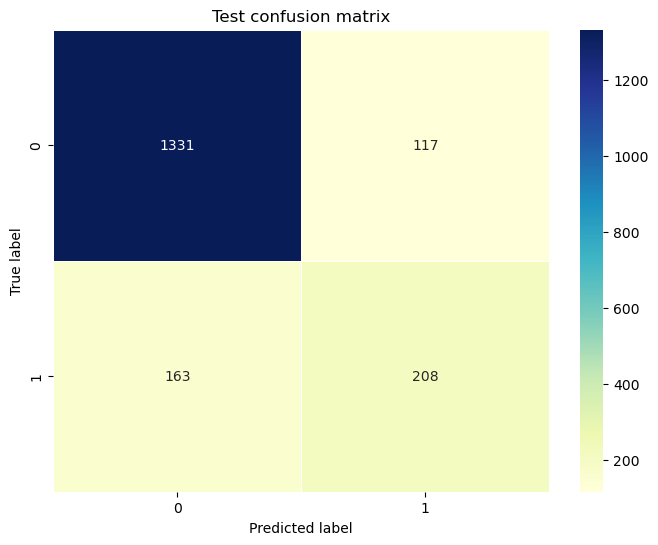

In [60]:
# Plot the confusion matrix
cm = confusion_matrix(target_test_drop, predicted_labels)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title('Test confusion matrix')     
sns.heatmap(cm, linewidth=0.5, ax=ax, annot=True, cmap='YlGnBu', fmt='d')

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label');

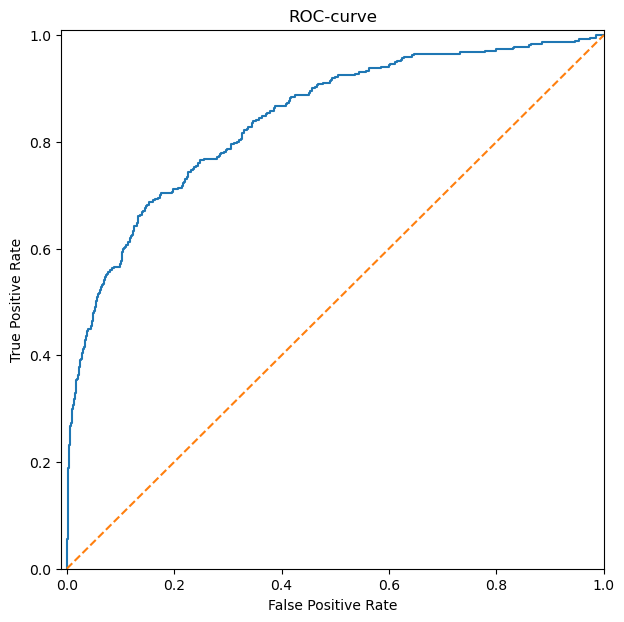

In [61]:
# Plot the ROC-curve
y_pred_prob = the_best_model_rfc_drop.predict_proba(features_test_drop)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test_drop, y_pred_prob)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.01])
plt.xlim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()

In [62]:
# Add feature importance
imp = (pd.DataFrame({'feature': features_test.columns,
                    'importance': the_best_model_rfc_drop.feature_importances_})
                    .sort_values(by='importance', ascending=False))
imp

,feature,importance
2,age,0.269927
5,num_of_products,0.136349
4,balance,0.112564
0,customer_id,0.101196
8,estimated_salary,0.100456
1,credit_score,0.098574
3,tenure,0.059804
7,is_active_member,0.042298
9,geography_germany,0.030053
11,gender_male,0.022744


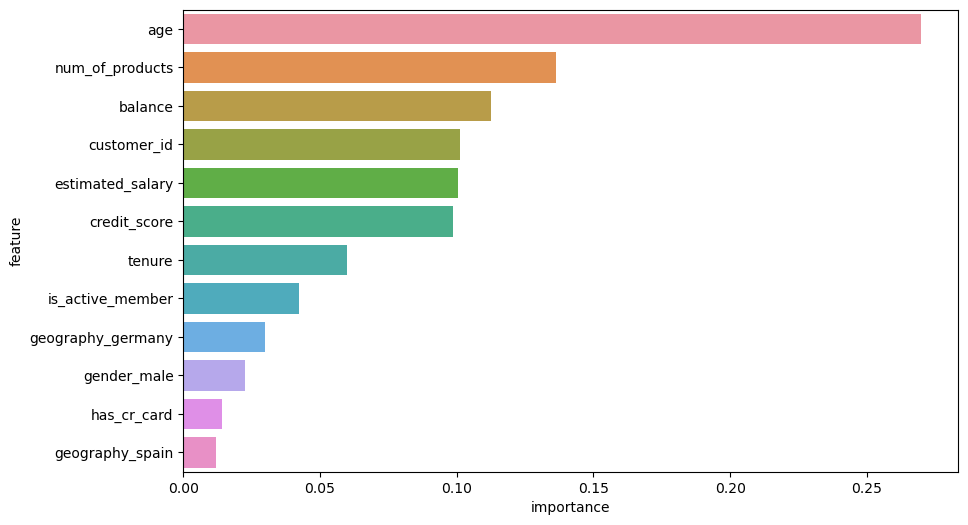

In [63]:
# Plot the feature importance
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=imp, ax=ax);

### Conclusion after model testing

The best model for predicting customer churn was found to be a Random Forest Classifier trained on an upsampled dataset to address the class imbalance issue with the drop strategy for missing values in the tenure column.

    * F1-score: 0.598
    * ROC AUC score: 0.842
    * Recall: 0.56
    * Precision: 0.64
        
The following hyperparameters were used:
    
    * n_estimators = 20
    * max_depth = 12
    * min_samples_split = 10
    * Dataset with deleted missing values.
    
Conclusion of the project:
    
* The model was trained on an upsampled dataset using the Upsample method, with the following hyperparameters:

The results of the model are far from perfect. The model predicts better for customers who do not plan to terminate their contract with the bank than for customers who do want to terminate their contract. However, our priority in this task is to predict the second category of clients. Nevertheless, the target F1 score has been achieved, and the ROC AUC score is also good.
    
    
* The Upsample method showed better performance in dealing with class imbalance.
    
    
* During the project, it was decided to handle missing values in two ways (deletion and imputation) and then decide which method is preferred.
    
    
* This was a mistaken decision to use both types of datasets with and without missing values treatment, as if the model was trained on one of these types, it is necessary to ensure that the same type of dataset (with or without missing values treatment) is used for validation and testing. Otherwise, the model will be predicting on the objects it was trained on, and the metrics will be artificially inflated.

* Overall, the project successfully demonstrated the application of machine learning techniques to solve a real-world problem. The results could be further improved by collecting more data or using more advanced algorithms.